# Exercise 4: Hamiltonian replica exchange molecular dynamics (HREMD)

## Instructor/Author
Wei-Tse Hsu
- University of Colorado Boulder
- www.weitsehsu.com
- wehs7661@colorado.edu
- [@WeiTseHsu](https://twitter.com/WeiTseHsu)

If you're interested, check my personal website for more future posts/tutorials about advanced sampling methods!

In this exercise, the goal is to run a Hamiltonian replica exchange molecule dynamics (HREMD) simulation for a 4-site system and calculate its solvation free energy. This 4-site system is composed of 4 linearly-connected interaction sites. 

Here, we will use 8 alchemical intermediate states (hence 8 replicas in the HREMD simulation) to gradually turn off van der Waals interactions between the molecule and the solvent environment. 

While the alchemical pathway (the $\lambda$ value for each state) should be indpedendent of the free energy, the choice of pathway will greatly affect the sampling efficiency. Here are a few rules of thumb: 
- Maximize the similiarity between neighboring states.
- Turn off charges before turning off the van der Waals interactions, so there won't be infinite attractive potential.
- Use the soft-core potential when turning off the van der Waals interactions to avoid the singularity problem.

## 1. Preparation of the input files

In [1]:
%%bash
# Here we remove the output of the exercise if there is any.
dirs=(state_* dhdl_files theta_files)
for dir in "${dirs[@]}"; do
    if ls -d "$dir" >/dev/null 2>&1; then
        rm -rf "$dir"
    fi
done

The major differences between an `mdp` file for REMD simulations and one for standard MD simulation lie in the options for free energy calculations and the specification of the alchemical variables. 

In [2]:
%%bash
tail -n 16 ../Inputs/4-site/HREMD.mdp


; Free energy calculation
free_energy              = yes
calc-lambda-neighbors    = -1
sc-alpha                 = 0.5
sc-power                 = 1 
couple-moltype           = LIG
couple-lambda0           = vdw-q
couple-lambda1           = none
init-lambda-state        = 0

nstdhdl                  = 100
dhdl-print-energy        = total

; lambda-states          = 1      2      3      4      5      6      7      8
vdw-lambdas              = 0.00   0.15   0.30   0.45   0.60   0.75   0.90   1.00


In [3]:
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

n=8      # number of alchemical intermediate states
for i in {0..7}
do
    mkdir state_${i} && cd state_${i}
    cp ../../Inputs/4-site/sys.gro .
    cp ../../Inputs/4-site/sys.top .
    cp ../../Inputs/4-site/HREMD.mdp .
    sed -i -e "s/init-lambda-state        = 0/init-lambda-state        = ${i}/g" HREMD.mdp
    mpirun -np 1 gmx_mpi grompp -f HREMD.mdp -c sys.gro -p sys.top -o HREMD.tpr && cd ../
done

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     1      Other residues
There are:   130      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...


Number of degrees of freedom in T-Coupling group System is 789.00
Estimate for the relative computational load of the PME mesh part: 0.42

GROMACS reminds you: "I couldn't claim that I was smarter than sixty-five other guys - but the average of sixty-five other guys, certainly!" (Richard Feynman)



Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.704 nm, buffer size 0.004 nm
Set rlist, assuming 4x4 atom pair-list, to 0.700 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.114 0.114 0.114
This run will generate roughly 3 Mb of data


                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     1      Other residues
There are:   130      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.704 nm, buffer size 0.004 nm
Set rlist, assuming 4x4 atom pair-list, to 0.700 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.114 0.114 0.114
This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 789.00
Estimate for the relative computational load of the PME mesh part: 0.42

GROMACS reminds you: "Rockets are cool. There's no getting around that." (Elon Musk)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz     

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     1      Other residues
There are:   130      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.704 nm, buffer size 0.004 nm
Set rlist, assuming 4x4 atom pair-list, to 0.700 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.114 0.114 0.114
This run will generate roughly 3 Mb of data


Velocities were taken from a Maxwell distribution at 300 K
Number of degrees of freedom in T-Coupling group System is 789.00
Estimate for the relative computational load of the PME mesh part: 0.42

GROMACS reminds you: "Uh-oh, We're In Trouble" (Shampoo)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sande

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     1      Other residues
There are:   130      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...


Number of degrees of freedom in T-Coupling group System is 789.00
Estimate for the relative computational load of the PME mesh part: 0.42

GROMACS reminds you: "Everything's formed from particles" (Van der Graaf Generator)



Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.704 nm, buffer size 0.004 nm
Set rlist, assuming 4x4 atom pair-list, to 0.700 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.114 0.114 0.114
This run will generate roughly 3 Mb of data


                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     1      Other residues
There are:   130      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.704 nm, buffer size 0.004 nm
Set rlist, assuming 4x4 atom pair-list, to 0.700 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.114 0.114 0.114
This run will generate roughly 3 Mb of data


                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     1      Other residues
There are:   130      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.704 nm, buffer size 0.004 nm
Set rlist, assuming 4x4 atom pair-list, to 0.700 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.114 0.114 0.114
This run will generate roughly 3 Mb of data


                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     1      Other residues
There are:   130      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.704 nm, buffer size 0.004 nm
Set rlist, assuming 4x4 atom pair-list, to 0.700 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.114 0.114 0.114
This run will generate roughly 3 Mb of data



GROMACS reminds you: "Player Sleeps With the Fishes" (Ein Bekanntes Spiel Von ID Software)

                 :-) GROMACS - gmx grompp, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennber

turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:     1      Other residues
There are:   130      Water residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 0.704 nm, buffer size 0.004 nm
Set rlist, assuming 4x4 atom pair-list, to 0.700 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.114 0.114 0.114
This run will generate roughly 3 Mb of data


Estimate for the relative computational load of the PME mesh part: 0.42

GROMACS reminds you: "Big Data is like teenage sex: everyone talks about it, nobody really knows how to do it, everyone thinks everyone else is doing it, so everyone claims they are doing it..." (Dan Ariely)



## 2. Running HREMD simulations

In [4]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0
mpirun -np 8 gmx_mpi mdrun -deffnm HREMD -dhdl dhdl.xvg -replex 100 -nex 512 -multidir state_0 state_1 state_2 state_3 state_4 state_5 state_6 state_7 -noappend -ntomp 1

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

CPU times: user 76.6 ms, sys: 12.3 ms, total: 88.9 ms
Wall time: 2min 37s


## 3. Data analysis

After the simulation is finished, an `dhdl*xvg` file should appear in each folder. These `*dhdl*xvg` files contain the derivative of the total energy (or potential energy) with respect to the $\lambda$ values, as a function of time. They are important for performing free energy calculations. 

In [5]:
%%bash
ls state_0/

HREMD.cpt
HREMD.mdp
HREMD.part0001.edr
HREMD.part0001.gro
HREMD.part0001.log
HREMD.part0001.xtc
HREMD.tpr
dhdl.part0001.xvg
mdout.mdp
sys.gro
sys.top


In [6]:
%%bash
mkdir dhdl_files && cd dhdl_files
for i in {0..7};
do
    mkdir state_${i}
    cp ../state_${i}/dhdl*xvg state_${i}/.
done

In [7]:
import os
import re
import glob
import natsort
import pymbar
import alchemlyb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from pymbar.timeseries import detect_equilibration, subsample_correlated_data
from alchemlyb.preprocessing import subsampling
from alchemlyb.estimators import MBAR
from alchemlyb.parsing.gmx import extract_u_nk
from alchemlyb.visualisation import plot_mbar_overlap_matrix 

# Just some settings for plotting
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


The protocol we adopt here for alchemical free energy calculations is composed of the following steps:
- **Step 1**: Collect all `dhdl*xvg` files from different folders/replicas.
- **Step 2**: For each replica, subsample the timeseries of $dH/d\lambda$ to get the uncorrelated samples. 
- **Step 3**: Concatenate the preprocessed data from all replicas. 
- **Step 4**: Feed the concatenated data to MBAR to calculate the free energy difference. 

In [8]:
N = 8      # number of replicas
T = 300    # simulation temperature
dhdl_dir = 'dhdl_files'

folders = [f'{dhdl_dir}/state_{i}' for i in range(N)]
u_nk_data = []
for i in range(N):
    files = glob.glob(os.path.join(folders[i], '*dhdl*xvg*'))
    files = natsort.natsorted(files, reverse=False)
    print(f'  Collecting data for the following files: {", ".join(files)}')
    u_nk = alchemlyb.concat([extract_u_nk(xvg, T=T) for xvg in files])
    u_nk_series = subsampling.u_nk2series(u_nk)
    u_nk, u_nk_series = subsampling._prepare_input(u_nk, u_nk_series, drop_duplicates=True, sort=True)
    u_nk = subsampling.slicing(u_nk, step=1)
    u_nk_series = subsampling.slicing(u_nk_series, step=1)
    
    t, statinef, Neff_max = detect_equilibration(u_nk_series.values)
    u_nk_series_equil, u_nk_equil = u_nk_series[t:], u_nk[t:]
    indices = subsample_correlated_data(u_nk_series_equil, g=statinef)
    preprocessed_u_nk = u_nk_equil.iloc[indices]
    u_nk_data.append(preprocessed_u_nk)

u_nk_data = alchemlyb.concat(u_nk_data)
print('  Fitting MBAR on u_nk ...')
try:
    mbar_stop = False
    mbar = MBAR().fit(u_nk_data)
except pymbar.utils.ParameterError():
    mbar_stop = True
    print("\sum_n W_nk is not equal to 1, probably due to insufficient overlap between states.")
    print("Stop using MBAR ...")

if mbar_stop is False:
    print(f"  MBAR: {mbar.delta_f_.iloc[0, -1]:.4f} +/- {mbar.d_delta_f_.iloc[0, -1]:.4f} kT")    

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


  Fitting MBAR on u_nk ...
  MBAR: -3.9518 +/- 0.1184 kT


From the MBAR estimator fitted on the dhdl data, we can also compute the overlap matrix, which is useful for tweaking the alchemical path if we want to improve the sampling. 

<Axes: >

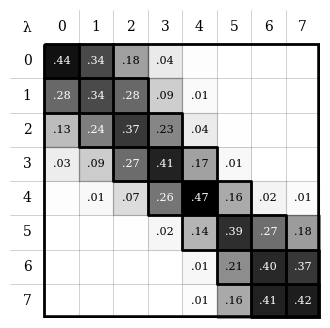

In [9]:
plot_mbar_overlap_matrix(mbar.overlap_matrix)

The `log` files document how what replicas were exchanged along the way, which allows us to recover the continuous trajecotry for each configuration (jumping between different alchemical sates). 

In [10]:
def get_HREX_trajs(log):
    """
    Parses the log file to get the state-space trajectory for each starting 
    configuraiton in a HREX simulation. As indicated in the source code "mdrun/replicaexchange.cpp",
    the "Order After Exchange" is the state label corresponding to the configuration
    that started in state listed in order, i.e. 3 0 1 2 means that the 
      - Configuration starting in state 3 (config 3) is now in state 0
      - Configuration starting in state 0 (config 0) is now in state 1
      - Configuration starting in state 1 (config 1) is now in state 2
      - Configuration starting in state 2 (config 2) is now in state 3
    Here, what we want to produce is a list of state-space trajectories with trajs[i] being
    the continuous trajectory of config i. 

    Parameters
    ----------
    log : str
        The filename of the log file to be parsed.
    
    Returns
    -------
    trajs : list
        A list of state-space trajectories.
    dt_traj : float
        Exchange period in ps.
    """
    f = open(log, 'r')
    lines = f.readlines()
    f.close()

    pattern = re.compile('Repl  There are \d+ replicas:')
    
    # First find relevant parameters
    for l in lines:
        if ' dt ' in l:
            dt = float(l.split('=')[-1]) # ps

        if 'gmx_mpi mdrun' in l:
            replex = int(l.split('-replex')[1].split()[0])

        if pattern.match(l):
            n_replicas = int(l.split('are')[-1].split('replicas')[0])
            break # this should be found last so we can break here

    trajs = [list(range(n_replicas))]  # always start from [0, 1, 2, ...]
    dt_traj = dt * replex   # exhcnage period in ps

    for l in lines:
        if 'Order After Exchange' in l:
            config_idx = [int(i) for i in l.split(':')[1].split()]
            state_idx = [config_idx.index(i) for i in range(n_replicas)]
            trajs.append(state_idx)
    trajs = np.array(trajs).T

    return trajs, dt_traj

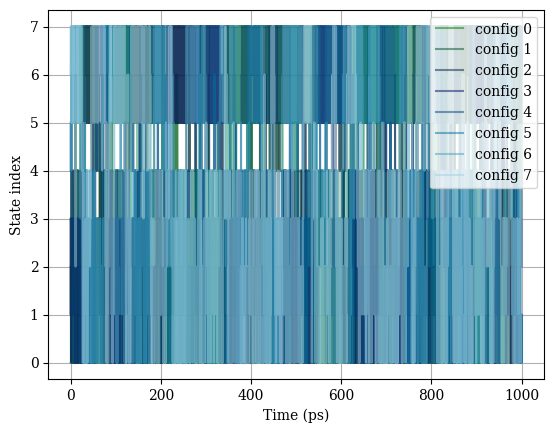

In [11]:
state_trajs, dt_traj = get_HREX_trajs('state_0/HREMD.part0001.log')
cmap = plt.cm.ocean
colors = [cmap(i) for i in np.arange(N) / N]

plt.figure()
for i in range(len(state_trajs)):
    plt.plot(np.arange(len(state_trajs[i])) * dt_traj, state_trajs[i], label=f'config {i}', alpha=0.5, color=colors[i])
    plt.xlabel('Time (ps)')
    plt.ylabel('State index')
    plt.legend()
plt.grid()

## References
- The paper that proposed the replica-exchange framework: [Sugita, Yuji, and Yuko Okamoto. "Replica-exchange molecular dynamics method for protein folding." Chemical physics letters 314.1-2 (1999): 141-151.](https://doi.org/10.1016/S0009-2614(99)01123-9)
- The paper that proposed Hamiltonian replica exchange: [Sugita, Yuji, Akio Kitao, and Yuko Okamoto. "Multidimensional replica-exchange method for free-energy calculations." The Journal of chemical physics 113.15 (2000): 6042-6051.](https://doi.org/10.1063/1.1308516)
- An excellent review on alchemical free energy methods: [Mey, Antonia SJS, et al. "Best practices for alchemical free energy calculations." arXiv preprint arXiv:2008.03067 (2020).](https://doi.org/10.33011/livecoms.2.1.18378)

## Takeaways

- The alchemical path should be tuned to make sure there is always overlap between neighboring intermediate states.
- Turn off charges before turning off the van der Waals interactions, so there won't be infinite attractive potential.
- Use the soft-core potential when turning off the van der Waals interactions to avoid the singularity problem.
- Using Hamiltonian replica exchange, we are able to calculate the solvation free energy of a molecule. 
- Given sufficient swapping, all configuraitons should be able to sample all alchemical intermediate states. 